In [ ]:
#### df = pd.read_csv('developer_survey_2018/survey_results_public.csv')

In [2]:
#df.info(verbose=True, null_counts=True)

In [ ]:
# columns_keep = ['Country', 'Student', 'Employment', 'FormalEducation', 'UndergradMajor', 'CompanySize',
#                'DevType','YearsCoding','JobSatisfaction','JobSearchStatus','LastNewJob',
#                'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith','PlatformWorkedWith',
#                'PlatformDesireNextYear','IDE','OperatingSystem',
#                'HoursComputer','HoursOutside','SkipMeals','Exercise','Gender','EducationParents','Age','Dependents']

# len(columns_keep)

In [ ]:
#df = df[columns_keep]

In [ ]:
#df.to_csv('selected_columns.csv')

In [1]:
from xgboost.sklearn import XGBClassifier
from matplotlib.pylab import rcParams
import xgboost as xgb
from sklearn import  metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np


from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:

df = pd.read_csv('selected_columns.csv', index_col = 0)

def regroup_country(x):
    if x != 'United States' and x != 'India' and pd.isnull(x) == False:
        x = 'Others_Country'
    return x
    
def regroup_education(x):
    if x != 'Bachelor’s degree (BA, BS, B.Eng., etc.)' and x != 'Master’s degree (MA, MS, M.Eng., MBA, etc.)' and x!= 'Other doctoral degree (Ph.D, Ed.D., etc.)' and pd.isnull(x) == False:
        x = 'Below Bachelor'
    try:
        x = x.replace('Bachelor’s degree (BA, BS, B.Eng., etc.)',"Bachelor")
        x = x.replace('Master’s degree (MA, MS, M.Eng., MBA, etc.)',"Master")
        x = x.replace('Other doctoral degree (Ph.D, Ed.D., etc.)',"PhD.")
    except:
        pass

    return x
    
def regroup_years_coding(x):
    try:
        x = x.replace('12-14 years',"12-17 years")
        x = x.replace('15-17 years',"12-17 years")
        x = x.replace('18-20 years',"18+ years")
        x = x.replace('21-23 years',"18+ years")
        x = x.replace('24-26 years',"18+ years")
        x = x.replace('27-29 years',"18+ years")
        x = x.replace('30 or more years',"18+ years")
    except:
        pass

    return x

def job_satisfaction_level(x):
    try:
        x = x.replace('Extremely dissatisfied','-3')
        x = x.replace('Moderately dissatisfied','-2')
        x = x.replace('Slightly dissatisfied','-1')
        x = x.replace('Neither satisfied nor dissatisfied','0')
        x = x.replace('Slightly satisfied','1')
        x = x.replace('Moderately satisfied','2')
        x = x.replace('Extremely satisfied','3')
        x = int(x)
    except:
        pass

    return x

def regroup_gender(x):
    if x != 'Male' and x != 'Female' and pd.isnull(x) == False:
        x = 'Other_Genders'
    return x

def regroup_age(x):
    try:
        x = x.replace('45 - 54 years old',"45 years or older")
        x = x.replace('55 - 64 years old',"45 years or older")
        x = x.replace('65 years or older',"45 years or older")
    except:
        pass

    return x


df['Country'] = df['Country'].apply(regroup_country)
df['FormalEducation'] = df['FormalEducation'].apply(regroup_education)
df['YearsCoding'] = df['YearsCoding'].apply(regroup_years_coding)
df['JobSatisfaction'] = df['JobSatisfaction'].apply(job_satisfaction_level)
df['Gender'] = df['Gender'].apply(regroup_gender)
df['EducationParents'] = df['EducationParents'].apply(regroup_education)
df['Age'] = df['Age'].apply(regroup_age)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df=df[df['Gender']!='Other_Genders']
features = list(df.columns)
features.remove('PlatformDesireNextYear')
features.remove('LanguageDesireNextYear')
df=df[features]

In [4]:
df['Employment']=df['Employment'].apply(lambda x:'Not Employed' 
                          if x in ['Not employed, but looking for work','Not employed, and not looking for work','Retired'
                                  ] else x)
df['Employment']=df['Employment'].apply(lambda x:'Self Employed' 
                          if x=='Independent contractor, freelancer, or self-employed' else x)

In [5]:
def regroup_undergrad_mojor(x):
    group1 = 'Computer_Background'
    group2 = 'Ohter_Engineering_Background'
    group3 = 'Non-Engineering/CS'
    group4 = 'Business'
    
    try:
        x = x.replace('A business discipline (ex. accounting, finance, marketing)',group4)
        x = x.replace('A health science (ex. nursing, pharmacy, radiology)',group3)
        x = x.replace('A humanities discipline (ex. literature, history, philosophy)',group3)
        x = x.replace('A social science (ex. anthropology, psychology, political science)',group3)
        x = x.replace('A natural science (ex. biology, chemistry, physics)',group2)
        x = x.replace('Another engineering discipline (ex. civil, electrical, mechanical)',group2)
        x = x.replace('Computer science, computer engineering, or software engineering',group1)
        x = x.replace('Fine arts or performing arts (ex. graphic design, music, studio art)',group3)
        x = x.replace('I never declared a major',group3)
        x = x.replace('Information systems, information technology, or system administration',group1)
        x = x.replace('Mathematics or statistics',group2)
        x = x.replace('Web development or web design',group1)
    except:
        pass
    
    return x

df['UndergradMajor'] = df['UndergradMajor'].apply(regroup_undergrad_mojor)

In [6]:
df=df.dropna(subset=['JobSearchStatus'])

In [7]:
df=df.dropna(subset=['EducationParents','Dependents','Gender','Age','Student','Employment'])

In [8]:
NAtoMostcommon = ["CompanySize","YearsCoding","HoursComputer","HoursOutside","SkipMeals","Exercise","LastNewJob",'FormalEducation']
for col in NAtoMostcommon:
    df[col] = df[col].fillna(df[col].value_counts().index[0])

In [9]:
df["JobSatisfaction"] = df["JobSatisfaction"].fillna(0)
df["UndergradMajor"] = df["UndergradMajor"].fillna('Non-Engineering/CS/Business')

In [10]:
dummy_columns=['DevType','LanguageWorkedWith','DatabaseWorkedWith','PlatformWorkedWith','IDE','OperatingSystem']
for x in dummy_columns:
    df1=df[x].str.get_dummies(sep=';')
    df=pd.concat([df,df1], axis=1)
    
df = df.drop(dummy_columns,axis=1)

In [11]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing[missing['Total']>0]

,Total,Percent


In [12]:
categorical_col = ['Country', 'Student', 'Employment', 'FormalEducation', 'UndergradMajor',
       'CompanySize', 'YearsCoding', 'LastNewJob', 'HoursComputer',
       'HoursOutside', 'SkipMeals', 'Exercise', 'Gender', 'EducationParents',
       'Age', 'Dependents']

for col in categorical_col:
    dummy_df = pd.get_dummies(df[col],drop_first=True)
    df = df.join(dummy_df, on= df.index , how='left', rsuffix= '_'+col)
    
df = df.drop(categorical_col,axis=1)

In [13]:
df['JobSearchStatus'].value_counts()

I’m not actively looking, but I am open to new opportunities    33252
I am not interested in new job opportunities                    14066
I am actively looking for a job                                  8086
Name: JobSearchStatus, dtype: int64

In [14]:
df=df[df['JobSearchStatus']!='I’m not actively looking, but I am open to new opportunities']

In [15]:
# dependent variable

# df['JobSearchStatus']=df['JobSearchStatus'].apply(lambda x: 0 if x=='I am not interested in new job opportunities' else x)
# df['JobSearchStatus']=df['JobSearchStatus'].apply(lambda x: 1 if x=='I’m not actively looking, but I am open to new opportunities' else x)
# df['JobSearchStatus']=df['JobSearchStatus'].apply(lambda x: 2 if x=='I am actively looking for a job' else x)
df['JobSearchStatus'].value_counts()

I am not interested in new job opportunities    14066
I am actively looking for a job                  8086
Name: JobSearchStatus, dtype: int64

In [16]:
df['JobSearchStatus']=df['JobSearchStatus'].apply(lambda x: 0 if x=='I am not interested in new job opportunities' else 1)
   

In [17]:
#df.to_csv('dummied_basic_features.csv')

In [18]:
train,test = train_test_split(df,train_size = 0.75,random_state=0)
features = list(df.columns)
features.remove('JobSearchStatus')
x_train = train[features]
y_train = train['JobSearchStatus']
x_test = test[features]
y_test = test['JobSearchStatus']

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

C:\Users\harry\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
y_pred = logreg.predict(x_test)

In [22]:
cross_val_score(logreg, x_train,y_train, cv=5).mean()

C:\Users\harry\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\harry\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\harry\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\harry\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\harry\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

0.8259901054464412

In [23]:
logreg.score(x_test,y_test)

0.8322499097146985

# Tree-based Models

## Decision Tree

In [74]:
evaluation=pd.DataFrame(columns=["Model","Train Cross_Validation accuracy",
                                 'Test Accuracy','Train Cross_Validation AUC','Test AUC'])

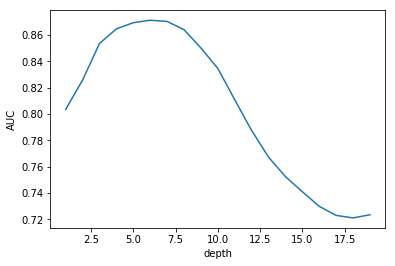

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
# Try trees with different max_depth and find the optimal max_depth
x = []
y = []
for i in range(1,20):
    model_1 = tree.DecisionTreeClassifier(max_depth=i)
    model_1.fit(x_train,y_train)
    x.append(i)
    #y.append(cross_val_score(model_1, x_train,y_train, cv=5).mean())
    y.append(cross_val_score(model_1, x_train,y_train, cv=5, scoring='roc_auc').mean())
plt.plot(x,y)
plt.xlabel('depth')
plt.ylabel('AUC')
plt.show()

In [76]:
# From the above plot,we can see that at the depth with 7, the decision model has the best auc.
tree_model = tree.DecisionTreeClassifier(max_depth = 7,criterion='entropy')
tree_model.fit(x_train,y_train)

tree_cross_accuracy=cross_val_score(tree_model, x_train,y_train, cv=5).mean()
tree_test_accuracy=tree_model.score(x_test,y_test)

ttest_predprob = tree_model.predict_proba(x_test)[:,1]
tree_cross_AUC=cross_val_score(tree_model, x_train,y_train, cv=5,scoring='roc_auc').mean()
tree_test_AUC=metrics.roc_auc_score(y_test,ttest_predprob)


r = evaluation.shape[0]
evaluation.loc[r] = ['Decision Tree',tree_cross_accuracy,tree_test_accuracy,tree_cross_AUC,tree_test_AUC]
evaluation
#tree_model.score(x_test,y_test)

,Model,Train Cross_Validation accuracy,Test Accuracy,Train Cross_Validation AUC,Test AUC
0,Decision Tree,0.811002,0.815096,0.871392,0.86935


## Random Forest

- Tune hyperparameters of Random Forest

In [34]:
parameters = {
     'n_estimators':[i for i in range(100,400,100)], # Number of trees
     'max_depth':list(range(8,15,2)),
     'min_samples_split': list(range(100,601,100)),
     'min_samples_leaf': list(range(100,601,100))
}
model_2 = GridSearchCV(RandomForestClassifier(),parameters,scoring="roc_auc", n_jobs=-1,cv=5,iid=False)
model_2.fit(x_train, np.ravel(y_train))
model_2.best_score_, model_2.best_params_

(0.8819904022230339,
 {'max_depth': 14,
  'min_samples_leaf': 100,
  'min_samples_split': 200,
  'n_estimators': 200})

In [35]:
parameters = {
     'n_estimators':[i for i in range(150,250,200)], # Number of trees
     'max_depth':list(range(12,18,2)),
     'min_samples_split': list(range(100,301,100)),
     'min_samples_leaf': list(range(100,301,50))
}
model_2 = GridSearchCV(RandomForestClassifier(),parameters,scoring="roc_auc", n_jobs=-1,cv=5,iid=False)
model_2.fit(x_train, np.ravel(y_train))
model_2.best_score_, model_2.best_params_

(0.8812628705635879,
 {'max_depth': 16,
  'min_samples_leaf': 100,
  'min_samples_split': 200,
  'n_estimators': 150})

- Random forest with optimal combination of hyperparameters

In [78]:
rf = RandomForestClassifier(max_depth= 14,min_samples_leaf = 100,min_samples_split= 200,n_estimators=150)

In [79]:
rf.fit(x_train,y_train)
rf_cross_accuracy=cross_val_score(rf, x_train,y_train, cv=5).mean()
rf_test_accuracy=rf.score(x_test,y_test)

rftest_predprob = rf.predict_proba(x_test)[:,1]
rf_cross_AUC=cross_val_score(rf, x_train,y_train, cv=5,scoring='roc_auc').mean()
rf_test_AUC=metrics.roc_auc_score(y_test,rftest_predprob)

r = evaluation.shape[0]
evaluation.loc[r] = ['Random Forest',rf_cross_accuracy,rf_test_accuracy, rf_cross_AUC, rf_test_AUC ]
evaluation

,Model,Train Cross_Validation accuracy,Test Accuracy,Train Cross_Validation AUC,Test AUC
0,Decision Tree,0.811002,0.815096,0.871392,0.869350
1,Random Forest,0.793367,0.793969,0.880312,0.879576


Text(0.5, 0, 'Relative Importance')

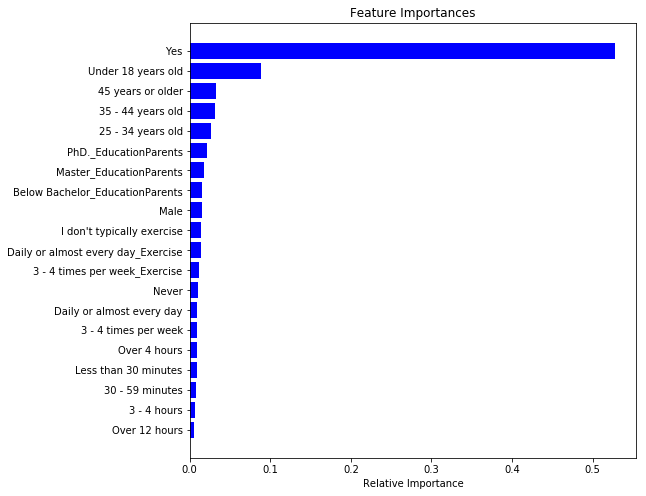

In [41]:
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,8))
plt.title('Feature Importances')
plt.barh(range(20), importances[indices][-20:], color='b', align='center')
plt.yticks(range(20),x_train.columns[-20:])
plt.xlabel('Relative Importance')

## XGBoost Classifier

In [80]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['JobSearchStatus'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)#, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['JobSearchStatus'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['JobSearchStatus'].values, dtrain_predictions))#np.mean(dtrain_predictions==y_train)
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['JobSearchStatus'], dtrain_predprob))

- Set the default starting xgboost and start tuning hyperparameters

In [49]:
#Choose all predictors except target & IDcols
predictors = features
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=10,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, predictors)


Model Report
Accuracy : 0.8977
AUC Score (Train): 0.960140


0.8977368484410738

- Keep learning_rate fixed and tuning tree related hyperparameters

In [51]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'n_estimators':range(100,600,100) 
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=8,iid=False, cv=5)
gsearch1.fit(train[features],train['JobSearchStatus'])
gsearch1.best_params_, gsearch1.best_score_


({'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 400},
 0.9083161742336054)

Given optimal max_depth is the minimum value of choices, thus expand the range of max_depth

In [52]:
param_test2 = {
 'max_depth':range(1,10,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=400, min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=8,iid=False, cv=5)
gsearch1.fit(train[features],train['JobSearchStatus'])
gsearch1.best_params_, gsearch1.best_score_


({'max_depth': 3}, 0.9083161742336054)

In [53]:
param_test2 = {
 'max_depth':range(5,8,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=400, min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=8,iid=False, cv=5)
gsearch1.fit(train[features],train['JobSearchStatus'])
gsearch1.best_params_, gsearch1.best_score_


({'max_depth': 5}, 0.9052009026000706)

In [54]:
param_test2 = {
 'max_depth':range(4,5,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=400, min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=8,iid=False, cv=5)
gsearch1.fit(train[features],train['JobSearchStatus'])
gsearch1.best_params_, gsearch1.best_score_


({'max_depth': 4}, 0.9074378785996092)

Thus optimal tree_related parameters: {'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 400}

- Tune parameter gamma

In [57]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=400, max_depth=4,
 min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=8,iid=False, cv=5)
gsearch3.fit(train[features],train['JobSearchStatus'])
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2}, 0.9078719777219861)

In [58]:
predictors = features
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=400,
 max_depth=4,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)

- Tune parameter subsample and colsample_bytree

In [60]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=400, max_depth=4,
 min_child_weight=3, gamma=0.2, 
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc', n_jobs=8, iid=False, cv=5)
gsearch4.fit(train[features],train['JobSearchStatus'])
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.8}, 0.9080870441303777)

In [61]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=400, max_depth=4,
 min_child_weight=3, gamma=0.2, 
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc', n_jobs=8, iid=False, cv=5)
gsearch5.fit(train[features],train['JobSearchStatus'])
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.75, 'subsample': 0.85}, 0.9080932142438598)

In [62]:
predictors = features
xgb5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=400,
 max_depth=4,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.85,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, train, predictors)

- Tune parameter reg_alpha

In [112]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=400, max_depth=4,
 min_child_weight=3, gamma=0.2, subsample=0.85, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=8,iid=False, cv=5)
gsearch6.fit(train[features],train['JobSearchStatus'])
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, 0.9080932923589126)

In [113]:
param_test6 = {
 'reg_alpha':[1e-6, 5e-6, 1e-5, 2e-5, 4e-5, 8e-5]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=400, max_depth=4,
 min_child_weight=3, gamma=0.2, subsample=0.85, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=8,iid=False, cv=5)
gsearch6.fit(train[features],train['JobSearchStatus'])
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, 0.9080932923589126)

In [114]:
param_test6 = {
 'reg_alpha':[0, 1e-8, 1e-7, 1e-6]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=400, max_depth=4,
 min_child_weight=3, gamma=0.2, subsample=0.85, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=8,iid=False, cv=5)
gsearch6.fit(train[features],train['JobSearchStatus'])
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 0}, 0.9080932142438598)

In [ ]:
# Thus, just ignore this parameter.

- Best XGBoost Classifier with optimal hyper-parameters

In [19]:
# Set learning rate from 0.1 to 0.01
# Set n_estimators from 400 to 4000 and below is the optimal model for XGBoost Classifier
predictors = features
xgb7 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=4000,
 max_depth=4,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.85,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [82]:
xgb7.fit(x_train,y_train)
xgb_cross_accuracy=cross_val_score(xgb7, x_train,y_train, cv=5).mean()
xgb_test_accuracy=xgb7.score(x_test,y_test)

xgbtest_predprob = xgb7.predict_proba(x_test)[:,1]
xgb_cross_AUC=cross_val_score(xgb7, x_train,y_train, cv=5,scoring='roc_auc').mean()
xgb_test_AUC=metrics.roc_auc_score(y_test,xgbtest_predprob)

r = evaluation.shape[0]
evaluation.loc[r] = ['XGBoost',xgb_cross_accuracy,xgb_test_accuracy, xgb_cross_AUC, xgb_test_AUC ]
evaluation

,Model,Train Cross_Validation accuracy,Test Accuracy,Train Cross_Validation AUC,Test AUC
0,Decision Tree,0.811002,0.815096,0.871392,0.869350
1,Random Forest,0.793367,0.793969,0.880312,0.879576
2,XGBoost,0.840074,0.836584,0.909305,0.905375


# Find optimal threshold for the best model

In [84]:
def get_classification(predictions,threshold):
    classes=np.zeros_like(predictions)
    for i in range(len(classes)):
        if predictions[i]>threshold:
            classes[i]=1
    return classes

In [86]:
from sklearn.metrics import confusion_matrix

In [103]:
income=30000
cost=1000
max=0
index=0
for i in range(1,100,3):
    tn,fp,fn,tp=confusion_matrix(y_test,get_classification(xgbtest_predprob,i*0.01)).ravel()
    p1=tp/(tp+fp) #precision
    p2=fp/(tp+fp)
    if p1*(income-cost)-p2*cost>max:
        max=p1*(income-cost)-p2*cost
        index=i*0.01
        
print(index,max)

0.91 27417.26618705036


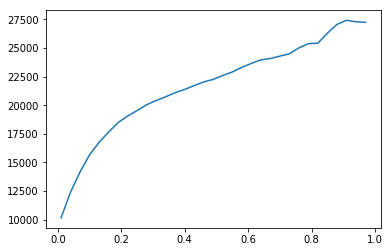

In [111]:
income=30000
cost=1000
profit=list()
index=list()
for i in range(1,100,3):
    tn,fp,fn,tp=confusion_matrix(y_test,get_classification(xgbtest_predprob,i*0.01)).ravel()
    p1=tp/(tp+fp) #precision
    p2=fp/(tp+fp)
    index.append(0.01*i)
    profit.append(p1*(income-cost)-p2*cost)
plt.plot(index,profit)